In [3]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

# 시각화 관련 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

# 데이터 준비, 모델 평가 관련 라이브러리
from sklearn import preprocessing as ppp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# 알고리즘 관련 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# MNIST data load

current_path = os.getcwd()
file = os.path.sep.join(['','mnist.pkl.gz'])

# 본인의 구글 드라이브(현재 디렉토리)에 mnist.pkl.gz 파일이 올라가 있어야 함!
# colab의 경우 content 폴더 바로 아래에 들어가면 됨

f = gzip.open(current_path+file, 'rb')

train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [9]:
# .shape을 활용해 각각의 데이터 크기를 확인합니다!

# X_train, y_train
print("Shape of X_train:      ", X_train.shape)
print("Shape of y_train:      ", y_train.shape)

# X_validation, y_validation (DIY!)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ",y_validation.shape)

# X_test, y_test (DIY!)
print("Shape of X_test:       ", X_test.shape)
print("Shape of y_test:       ", y_test.shape)

Shape of X_train:       (50000, 784)
Shape of y_train:       (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:        (10000, 784)
Shape of y_test:        (10000,)


In [10]:
# Pandas dataframe 형태로 데이터를 변환합니다.

train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train)+len(X_validation),
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

In [12]:
y_train.head() #라벨확인

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [13]:
# 이미지 시각화 함수 view_digit()
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28, 28])
    plt.title('Example: %d     /     Label: %d'%(example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

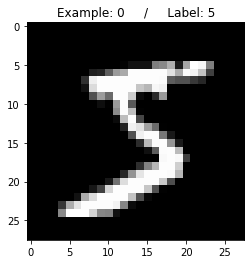

In [14]:
# 첫번째 X_train 이미지 열기

# 제대로 함수가 정의됐다면 '5' 를 손으로 쓴 이미지가 보여야 합니다!
view_digit(0)

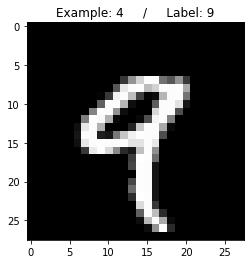

In [15]:
# 다섯번째 X_train 이미지 열기 (DIY!)

view_digit(4)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 784)

In [17]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [18]:
# pca.explained_variance_ratio_
# 전체 주성분을 모두 사용하는 경우

print("전체 784개의 주성분에 의해 설명되는 분산(정보량)의 비율은, ",
      sum(pca.explained_variance_ratio_), "입니다.")

전체 784개의 주성분에 의해 설명되는 분산(정보량)의 비율은,  0.9999999871732004 입니다.


In [19]:
# If X is not 784,

importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)

importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print("첫 10개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:9].sum(axis=1).values, "입니다.")

# DIY! (???를 채워 주세요.)
print("첫 20개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:19].sum(axis=1).values, "입니다.")
print("첫 50개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:49].sum(axis=1).values, "입니다.")
print("첫 100개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:99].sum(axis=1).values, "입니다.")
print("첫 200개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:199].sum(axis=1).values, "입니다.")
print("첫 300개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:299].sum(axis=1).values, "입니다.")

첫 10개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.48876226] 입니다.
첫 20개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.6439802] 입니다.
첫 50개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.8248609] 입니다.
첫 100개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.9146585] 입니다.
첫 200개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.9665007] 입니다.
첫 300개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.9862489] 입니다.


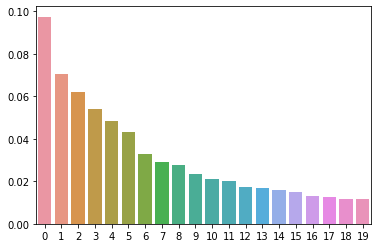

In [24]:
# data = ___________________ 부분을 채워 주세요!
sns.barplot(
    data=  importanceOfPrincipalComponents.loc[:, 0:19]
)
plt.show()

In [42]:
# 참고!
# 저는 아래와 같은 코드를 사용했으며, 더 좋은 방식이 있을 수 있습니다!
# ??? 부분을 채워 주세요!

cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

cumulative = pd.DataFrame(data=cumulative)
CumulativeImportanceOfPrincipalComponents = cumulative.T

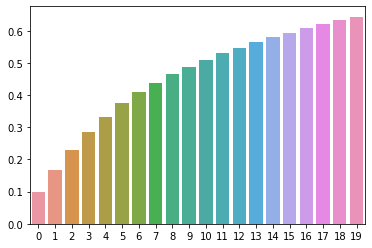

In [43]:
sns.barplot(
    data= CumulativeImportanceOfPrincipalComponents.loc[:, 0:19]
)
plt.show()

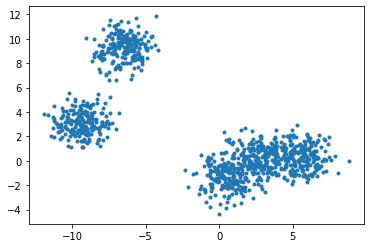

In [45]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_center = 5

# Example Data 생성
X, y = make_blobs(n_samples=1000, centers=n_center, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], marker='.')

In [46]:
# Cluster 생성

k_means = KMeans(n_clusters=n_center, n_init=12)
k_means.fit(X)

k_means_labels = k_means.labels_
print('k_means_labels : ', k_means_labels)

k_means_cluster_centers = k_means.cluster_centers_
print('k_means_cluster_centers : ', k_means_cluster_centers)

k_means_labels :  [4 3 1 0 1 2 2 4 4 3 2 0 3 2 3 2 2 4 4 1 4 0 1 0 0 3 3 1 4 2 2 2 4 1 4 0 0
 2 2 4 1 2 4 3 0 3 1 3 2 4 3 3 1 3 1 2 0 2 0 1 3 0 1 0 1 4 0 3 4 1 2 4 0 1
 2 3 4 2 1 0 2 2 0 0 3 1 1 4 1 3 4 2 1 2 0 2 0 4 4 0 0 3 0 4 3 1 4 3 4 2 1
 4 3 2 1 3 2 4 2 4 4 4 4 3 1 4 3 0 3 4 3 2 2 3 3 3 0 2 4 1 2 3 0 4 0 1 0 0
 4 4 4 1 2 2 1 0 4 4 2 1 3 1 2 2 2 4 0 1 3 1 3 3 0 2 1 2 4 1 1 0 1 0 0 3 0
 2 3 1 2 4 3 4 2 2 4 4 1 0 4 3 1 0 3 1 3 1 1 0 4 0 0 2 0 0 1 0 3 4 0 1 4 1
 3 4 4 1 4 1 0 1 0 2 3 0 3 1 1 4 2 3 3 3 4 3 0 3 3 0 4 2 2 1 4 0 4 0 4 0 1
 0 4 0 2 2 0 2 3 2 3 2 2 2 0 4 2 3 3 4 4 4 3 0 1 0 3 4 4 2 4 2 4 4 1 0 0 1
 0 1 3 3 0 0 1 1 0 1 4 0 3 0 1 1 4 3 2 0 4 2 2 1 1 1 3 0 2 2 2 0 1 2 3 2 1
 3 3 1 1 0 0 0 3 1 1 0 0 3 2 3 1 2 2 4 1 1 4 1 4 2 1 1 3 1 3 1 3 2 2 0 1 0
 0 3 3 4 3 3 3 2 2 4 0 0 3 1 2 1 1 2 2 1 0 0 0 3 1 2 2 4 1 0 0 2 0 4 2 3 1
 1 3 2 2 0 3 2 3 3 0 2 4 2 0 0 0 1 0 4 0 4 3 2 2 1 0 4 0 4 0 3 2 4 4 1 3 0
 4 1 3 4 0 0 4 4 3 0 0 4 1 3 3 3 4 4 0 0 0 2 2 4 1 3 1 1 1 0 0 1 1 4 2 4 4
 2 2 1 

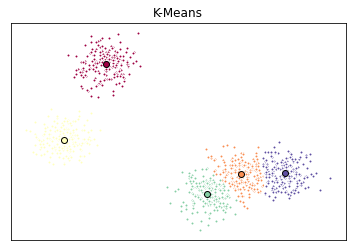

In [47]:
# 지정된 크기로 초기화
fig = plt.figure(figsize=(6, 4))

# 레이블 수에 따라 색상 배열 생성, 고유한 색상을 얻기 위해 set(k_means_labels) 설정
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# plot 생성
ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n_center), colors):
    my_members = (k_means_labels == k)

    # 중심 정의
    cluster_center = k_means_cluster_centers[k]

    # 중심 그리기
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

ax.set_title('K-Means')
ax.set_xticks(())
ax.set_yticks(())
plt.show()